#   1. Config the environment

In [1]:
import tensorflow as tf

# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import random


##   1.1 Preparing the data set

In [2]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

## 1.2 Prepare the corresponding function

In [3]:
loss_object = tf.keras.losses.CategoricalCrossentropy()


# Function to calculate adversary noise
def generate_gradient(image, label):
  image = tf.cast(image, tf.float32)

  label = tf.one_hot(label, 10)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(tf.reshape(image, [1, 32, 32, 3]))[0]
    loss = loss_object(label, prediction)
  gradient = tape.gradient(loss, image)

  #return sign_grad
  return gradient

In [4]:
def DeepFool(image, label, model, limit_times):

    label = label[0]

    #print(label)

    image = tf.cast(image, tf.float32)
    image_ori = image

    store_list = []
    store_list.append(image_ori)
    i = 0

    while model(tf.reshape(store_list[i], [1, 32, 32, 3])).numpy().argmax() == model(tf.reshape(image_ori, [1, 32, 32, 3])).numpy().argmax() and i < limit_times:

        #print('start, time:', i)
        
        predict_vector = model(tf.reshape(store_list[i], [1, 32, 32, 3]))[0]

        gradient_ori = generate_gradient(store_list[i], label)
        predict_vector_ori = predict_vector[label]

        gradient_difference = []
        predict_vector_difference = []
        l_list = []


        # total 10 classification
        for j in range(10):
            predict_vector_difference.append(tf.math.abs(predict_vector[j] - predict_vector_ori))

            #print(f'predict_vector_difference {predict_vector[j] - predict_vector_ori}')

            gradient = generate_gradient(store_list[i], j)
            gradient_difference.append(gradient - gradient_ori)

            #print(f'gradient_difference append {gradient - gradient_ori}')

        #print(predict_vector_difference)
        #print(gradient_difference)


        for j in range(10):
            if j != label:
                tmp_1 = tf.math.abs(predict_vector_difference[j])
                tmp_2 = tf.math.reduce_euclidean_norm(gradient_difference[j])

                result = tf.math.divide(tmp_1, tmp_2)

                #print(f'list append {result}')

                l_list.append(result)
            else:
                l_list.append(1)

                #print(f'list append {0}')

        #print(type(l_list))
        #print(np.asarray(l_list))
        
        l = np.asarray(l_list).argmin()
        #print(f'l == {l}')

        #disturbance = np.clip((predict_vector_difference[l] / np.square(np.linalg.norm(gradient_difference[l]))) * gradient_difference[l], -1, 1)
        #disturbance = (tf.math.abs(tf.get_static_value(predict_vector_difference[l])) / np.square(np.linalg.norm(tf.get_static_value(gradient_difference[l])))) * tf.get_static_value(gradient_difference[l])

        disturbance = tf.math.divide_no_nan(tf.math.abs(predict_vector_difference[l]), tf.math.square(tf.math.reduce_euclidean_norm(gradient_difference[l])))
        disturbance = tf.math.multiply_no_nan(disturbance, gradient_difference[l])

        #print(disturbance)
        

        store_list.append(tf.clip_by_value(store_list[i] + disturbance, 0, 1))
        i += 1

    true_disturbance = store_list[i] - image_ori

    return store_list[i], true_disturbance
    #return predict_vector_difference, gradient_difference


# 2. Test function in different models and dataset, plot the difference

In [5]:
def show_difference(input_image, input_image_label, model, Iteration_num):
    
    image_adv, disturbance = DeepFool(input_image, input_image_label, model, Iteration_num)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Plot the adv image and the disturbance')
    ax1.imshow(input_image)
    ax1.set_title(f'Original image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(input_image, [1, 32, 32, 3]))[0]))]}')
    ax2.imshow(image_adv.numpy().reshape(32, 32, 3))
    ax2.set_title(f'Adv image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]))]}')
    ax3.imshow( tf.clip_by_value(disturbance, 0, 1))
    ax3.set_title('Disturbance')


In [6]:
model = tf.keras.models.load_model('../../../build/saved_model/Simple_CNN/HDF5/Simple_CN.h5', compile=True)

2022-08-27 01:35:08.272256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-27 01:35:08.285132: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


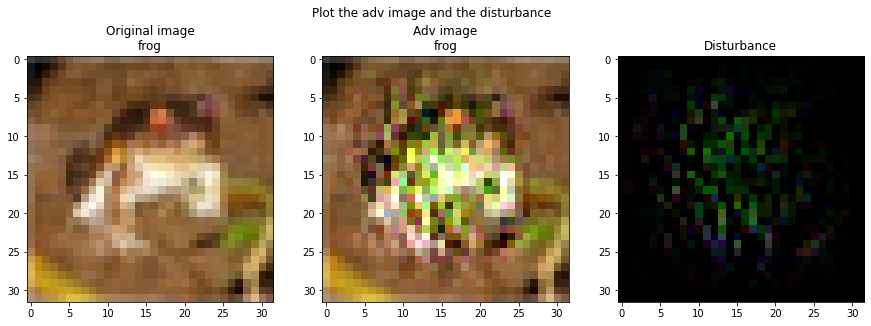

In [7]:
show_difference(train_images[0], train_labels[0], model, 50)

## 2.1 Use cifar10 test set for a single test

In [8]:
#random_num = random.randint(0, len(test_images))
random_num = np.random.randint(0, len(train_images))
Iteration_num = 100
test_image = train_images[random_num]
test_label = train_labels[random_num]

## 2.1.1 Test Simple-CNN model

In [9]:
model = tf.keras.models.load_model('../../../build/saved_model/Simple_CNN/HDF5/Simple_CN.h5', compile=True)

In [10]:
image_adv, disturbance = DeepFool(test_image, test_label, model, Iteration_num)

Text(0.5, 1.0, 'Disturbance')

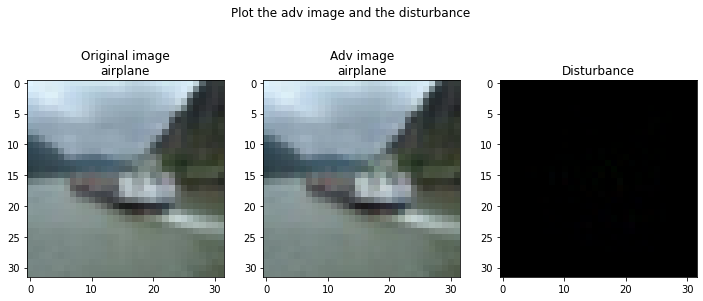

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Plot the adv image and the disturbance')
ax1.imshow(test_image)
ax1.set_title(f'Original image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(test_image, [1, 32, 32, 3]))[0]))]}')
ax2.imshow(image_adv.numpy().reshape(32, 32, 3))
ax2.set_title(f'Adv image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]))]}')
ax3.imshow( tf.clip_by_value(disturbance, 0, 1))
ax3.set_title('Disturbance')

## 2.1.2 Test VGG19 model

In [12]:
model = tf.keras.models.load_model('../../../build/saved_model/VGG19_TransferLearning/HDF5/VGG19_TransferLearning.h5', compile=True)

In [13]:
image_adv, disturbance = DeepFool(test_image, test_label, model, Iteration_num)

Text(0.5, 1.0, 'Disturbance')

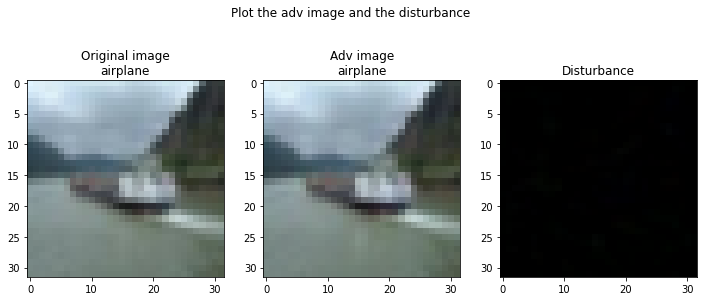

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Plot the adv image and the disturbance')
ax1.imshow(test_image)
ax1.set_title(f'Original image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(test_image, [1, 32, 32, 3]))[0]))]}')
ax2.imshow(image_adv.numpy().reshape(32, 32, 3))
ax2.set_title(f'Adv image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]))]}')
ax3.imshow( tf.clip_by_value(disturbance, 0, 1))
ax3.set_title('Disturbance')

## 2.1.3 Test ResNet model

In [15]:
model = tf.keras.models.load_model('../../../build/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5', compile=True)

In [16]:
image_adv, disturbance = DeepFool(test_image, test_label, model, Iteration_num)

Text(0.5, 1.0, 'Disturbance')

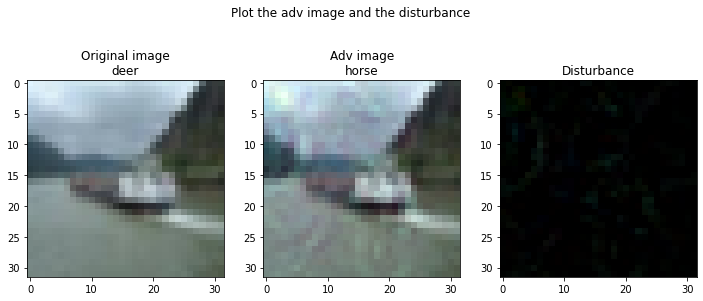

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Plot the adv image and the disturbance')
ax1.imshow(test_image)
ax1.set_title(f'Original image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(test_image, [1, 32, 32, 3]))[0]))]}')
ax2.imshow(image_adv.numpy().reshape(32, 32, 3))
ax2.set_title(f'Adv image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]))]}')
ax3.imshow( tf.clip_by_value(disturbance, 0, 1))
ax3.set_title('Disturbance')

## 2.1.4 Test DenseNet121 model

In [18]:
model = tf.keras.models.load_model('../../../build/saved_model/DenseNet121_TransferLearning/HDF5/DenseNet121_TransferLearning.h5', compile=True)

In [19]:
image_adv, disturbance = DeepFool(test_image, test_label, model, Iteration_num)

Text(0.5, 1.0, 'Disturbance')

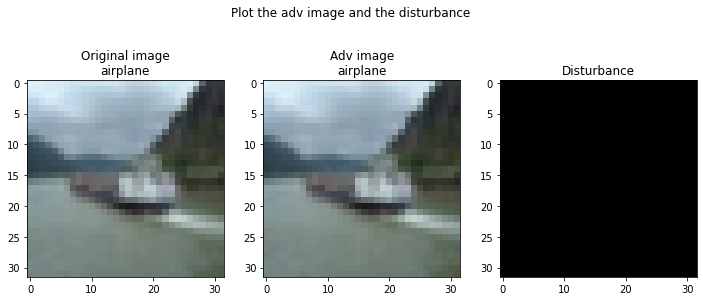

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Plot the adv image and the disturbance')
ax1.imshow(test_image)
ax1.set_title(f'Original image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(test_image, [1, 32, 32, 3]))[0]))]}')
ax2.imshow(image_adv.numpy().reshape(32, 32, 3))
ax2.set_title(f'Adv image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]))]}')
ax3.imshow( tf.clip_by_value(disturbance, 0, 1))
ax3.set_title('Disturbance')

## 2.1.5 Test ResNet V2 model

In [21]:
model = tf.keras.models.load_model('../../../build/saved_model/ResNet_V2_TransferLearning/ResNet_V2.h5', compile=True)

In [22]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

test_image = train_images[random_num]

test_image = tf.keras.applications.resnet_v2.preprocess_input(test_image)

In [23]:
image_adv, disturbance = DeepFool(test_image, test_label, model, Iteration_num)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Disturbance')

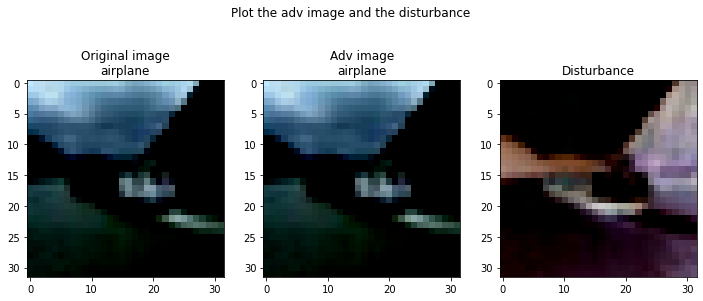

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Plot the adv image and the disturbance')
ax1.imshow(test_image)
ax1.set_title(f'Original image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(test_image, [1, 32, 32, 3]))[0]))]}')
ax2.imshow(image_adv.numpy().reshape(32, 32, 3))
ax2.set_title(f'Adv image\n{label_names[tf.get_static_value(tf.argmax(model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]))]}')
ax3.imshow( tf.clip_by_value(disturbance, 0, 1))
ax3.set_title('Disturbance')